This Jupytr notebook 

In [95]:
import requests
import builtins
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

Constants for file locations and column mappings used in processing GHCND climate data.

In [160]:
# Constants to navigate the data
STATE_CODE = "IA" # state code according to ghcnd-states.
# Sample row: "CA001039040  50.0333 -126.8167   91.0 BC ZEBALLOS IRON MINES"
STATION_FILE_COLUMNS_MAPPING = {
    "ID": [0, 11],
    "STATE": [38, 40],
}
STATION_DATA_COLUMN_MAPPING = {
    "ID": [0, 11],
    "YEAR": [11, 15],
    "MONTH": [15, 17],
    "ELEMENT_TYPE": [17, 21],
}
# Positions for daily values within .dly lines (see GHCND readme)
VALUE_START_INDEX = 21  # zero-based (1-based column 22)
VALUE_FIELD_WIDTH = 5
VALUE_BLOCK_WIDTH = 8  # value + 3 flag characters
NUM_DAYS_PER_MONTH = 31
# Months we're interested in when crops are sensitive to temp
MONTHS_FILTER = ["06", "07", "08"]

# For downloading data
GHCND_DOWNLOAD_LOCATION = "https://www.ncei.noaa.gov/pub/data/ghcn/daily/all/{}.dly" # location to download data files, format with station ID
GHCND_STATION_FILE_LOCATION = "https://www.ncei.noaa.gov/pub/data/ghcn/daily/ghcnd-stations.txt" # location to download ghcnd station file

# For predownloaded data
GHCND_BASE_LOCATION = "./data/climate_data" # base location of ghcnd data files
STATION_FILE = f"{GHCND_BASE_LOCATION}/raw_data/ghcnd-stations.txt" # ghcnd station file
GHCND_OUTPUT_FILE = f"{GHCND_BASE_LOCATION}/processed/ghcnd-{STATE_CODE}-data.csv" # output file for state data


Pull data from DLV files

In [165]:
def load_or_download_file(url, local_path):
    """Load a file from local path or download it if not present."""
    try:
        f = builtins.open(local_path, 'r')
        file_data = (line for line in f)
        df = pd.DataFrame(file_data, columns=["line"])
        f.close()
    except FileNotFoundError:
        response = requests.get(url)
        response.raise_for_status()
        data = response.text
        file_path = Path(local_path)
        file_path.parent.mkdir(parents=True, exist_ok=True)
        with builtins.open(local_path, 'w') as f:
            f.write(data)

        f = builtins.open(local_path, 'r')
        file_data = (line for line in f)
        df = pd.DataFrame(file_data, columns=["line"])
        f.close()

    return df

def extract_daily_values(line):
    """Extract daily values from a .dly line (ignores flags)."""
    values = []
    for day_idx in range(NUM_DAYS_PER_MONTH):
        start = VALUE_START_INDEX + day_idx * VALUE_BLOCK_WIDTH
        end = start + VALUE_FIELD_WIDTH
        raw_val = line[start:end].strip()
        if not raw_val:
            continue
        try:
            val = int(raw_val)
        except ValueError:
            continue
        if val == -9999:
            continue
        values.append(val)
    return values

def monthly_mean_celsius(line):
    """Compute the mean of all valid daily values in tenths °C, returned in °C."""
    vals = extract_daily_values(line)
    if not vals:
        return None
    return sum(vals) / (len(vals) * 10.0)

def dlv_to_filtered_df(df):
    """
    Convert a DLV file to a pandas DataFrame.
    1. Load entire DLV file into a DataFrame. With 1 single row per observation.
    2. Split the first column into multiple columns based on fixed width.
    3. Compute monthly mean for each line across all valid daily values (ignoring -9999).
    4. Filter for ELEMENT_TYPE = TMAX or TMIN by creating two separate dataframes and merging them on MONTH and YEAR.
    5. Calculate TAVG as the average of TMAX and TMIN (all in °C).
    6. Return the final DataFrame.
    """
    for col_name, (start, end) in STATION_DATA_COLUMN_MAPPING.items():
        df[col_name] = df["line"].str[start:end].str.strip()
    df["MONTHLY_MEAN"] = df["line"].apply(monthly_mean_celsius)
    df = df[list(STATION_DATA_COLUMN_MAPPING.keys()) + ["MONTHLY_MEAN"]]
    df = df[df["MONTH"].isin(MONTHS_FILTER)]
    df = df.dropna(subset=["MONTHLY_MEAN"])

    tmax_df = df[df["ELEMENT_TYPE"] == "TMAX"][['YEAR', 'MONTH', 'ID', 'MONTHLY_MEAN']].rename(columns={"MONTHLY_MEAN": "TMAX"})
    tmin_df = df[df["ELEMENT_TYPE"] == "TMIN"][['YEAR', 'MONTH', 'ID', 'MONTHLY_MEAN']].rename(columns={"MONTHLY_MEAN": "TMIN"})

    merged_df = pd.merge(tmax_df, tmin_df, on=["YEAR", "MONTH", "ID"], how="outer")
    merged_df["TAVG"] = (merged_df["TMAX"] + merged_df["TMIN"]) / 2
    merged_df["YEAR"] = merged_df["YEAR"].astype('int64')
    return merged_df

def get_state_stations(state_code=STATE_CODE):
    """Get list of station IDs for the specified state."""
    df = load_or_download_file(
        GHCND_STATION_FILE_LOCATION,
        STATION_FILE
    )
    for col_name, (start, end) in STATION_FILE_COLUMNS_MAPPING.items():
        df[col_name] = df["line"].str[start:end].str.strip()
    stations_df = df[list(STATION_FILE_COLUMNS_MAPPING.keys())]
    state_stations_df = stations_df[stations_df["STATE"] == state_code]
    stations_list = state_stations_df["ID"].tolist()
    return stations_list

def get_state_data(state_code=STATE_CODE):
    """Get climate data for the specified state."""
    stations_list = get_state_stations(state_code)
    all_data_df = pd.DataFrame()
    for station_id in stations_list:
        station_data_df = load_or_download_file(
            GHCND_DOWNLOAD_LOCATION.format(station_id),
            f"{GHCND_BASE_LOCATION}/raw_data/ghcnd_gsn/{station_id}.dlv"
        )

        try:
            station_data_df = dlv_to_filtered_df(station_data_df)
            all_data_df = pd.concat([all_data_df, station_data_df], ignore_index=True)
        except FileNotFoundError:
            print(f"DLV file not found for station {station_id}, skipping.")
    return all_data_df

def get_mean_temperature_per_year(state_code=STATE_CODE):
    """Get mean temperature per year for the specified state."""
    try:
        file_path = Path(GHCND_OUTPUT_FILE)
        file_path.parent.mkdir(parents=True, exist_ok=True)        
        
        mean_temp_per_year_df = pd.read_csv(GHCND_OUTPUT_FILE)
    except FileNotFoundError:
        state_data_df = get_state_data(state_code)
        grouped = state_data_df.groupby("YEAR").agg(
            TAVG=("TAVG", "mean"),
            TMAX=("TMAX", "mean"),
            TMIN=("TMIN", "mean"),
        ).reset_index()
        mean_temp_per_year_df = grouped.round({"TAVG": 1, "TMAX": 1, "TMIN": 1})
        mean_temp_per_year_df.rename(columns={
            "TAVG": "Average Temperature",
            "TMAX": "Average TMAX",
            "TMIN": "Average TMIN",
        }, inplace=True)
        mean_temp_per_year_df.to_csv(GHCND_OUTPUT_FILE, index=False)
    return mean_temp_per_year_df

mean_temperature_per_year_df = get_mean_temperature_per_year()


Pull data from crop.csv

In [98]:
CROP_DATA_BASE_LOCATION = "./data/crop_data" # base location of crop data files
STATE = "IOWA" # state name for crop data

# For predownloaded data
CROP_DATA_FILE = f"{CROP_DATA_BASE_LOCATION}/raw_data/corn.csv" # crop data
CROP_OUTPUT_FILE = f"{CROP_DATA_BASE_LOCATION}/processed/crop.csv" # output file for crop data

In [119]:
def load_crop_data():
    """Load crop data from CSV file."""
    try:
        crop_df = pd.read_csv(CROP_OUTPUT_FILE)
    except FileNotFoundError:
        crop_df = pd.read_csv(CROP_DATA_FILE, header=0)
        crop_df = crop_df[
            (crop_df["Period"] == "YEAR") &\
            (crop_df["State"] == STATE) &\
            (crop_df["Commodity"] == "CORN")
        ]
        crop_df = crop_df[["Year", "Value"]]
        crop_df.rename(columns={"Year": "YEAR"}, inplace=True)
        crop_df.rename(columns={"Value": "Yield"}, inplace=True)

        file_path = Path(CROP_OUTPUT_FILE)
        file_path.parent.mkdir(parents=True, exist_ok=True)        
        crop_data_df.to_csv(CROP_OUTPUT_FILE, index=False)
    return crop_df

crop_data_df = load_crop_data()

Merge the data into a single data frame

In [158]:
MERGED_OUTPUT_FILE = "./data/merged/crop_yield_and_temperature.csv"

In [166]:
def merge_crop_and_temp_data(crop_df, temp_df):
    df = pd.merge(crop_df, temp_df, on="YEAR", how="inner")
    df.to_csv(MERGED_OUTPUT_FILE, index=False)
    return df

merged_df = merge_crop_and_temp_data(crop_data_df, mean_temperature_per_year_df)

Draw graphs based on the dataframe to compare averge temperatures to crop yield

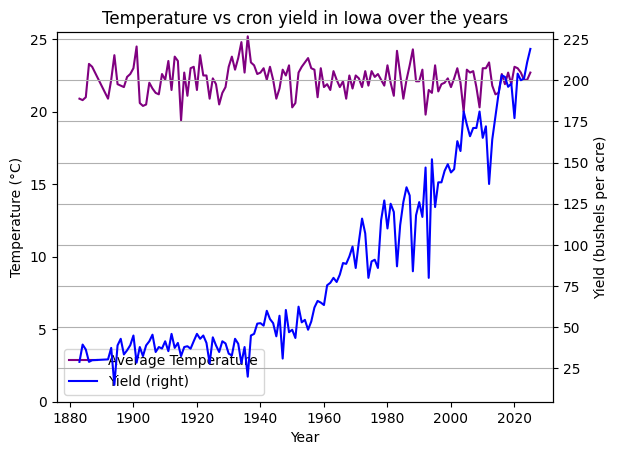

In [171]:
def plot_df(df):
    _, axis = plt.subplots()
    df.plot(x="YEAR", y="Average Temperature", ax=axis, color="purple", label="Average Temperature")
    # df.plot(x="YEAR", y="Average TMAX", ax=axis, color="red", label="Average Max temperature")
    # df.plot(x="YEAR", y="Average TMIN", ax=axis, color="green", label="Average Min temperature")
    df.plot(x="YEAR", y="Yield", ax=axis, color="blue", label="Yield", secondary_y=True)

    axis.set_xlabel("Year")
    axis.set_ylabel("Temperature (°C)")
    axis.set_ylim(bottom=0)
    axis.right_ax.set_ylabel("Yield (bushels per acre)")

    plt.title(f"Temperature vs cron yield in {STATE.title()} over the years")
    plt.grid(True)
    plt.show()

plot_df(merged_df)